# The Single Stock - analysis

The notebook here allows to perform analysis for a single exchange security (shares).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Data downloading

In [2]:
start = '2012-01-01'
end = '2017-12-31'
stock_symbol = 'SLV'

# Uncomment line below to download latest quotes for stocks
#%run ../money_machine_app/downloaders/stocks_data_downloader.py $start $end $stock_symbol

### Data preprocessing

In [3]:
# The CSV file has following columns: 
# Data, Otwarcie, Najwyzszy, Najnizszy, Zamkniecie, Wolumen
stock = pd.read_csv(f'../data-archive/stocks/{stock_symbol}.csv',
                   delimiter=',',
                   index_col='Data',
                   parse_dates=True)

In [4]:
# drop unnecessary columns
stock.drop(['Otwarcie', 'Najwyzszy', 'Najnizszy'], axis=1, inplace=True)

# rename column and index
stock.columns = ['Close', 'Volume']
stock.index.names = ['Date']

In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1448 entries, 2012-01-02 to 2017-10-19
Data columns (total 2 columns):
Close     1448 non-null float64
Volume    1448 non-null int64
dtypes: float64(1), int64(1)
memory usage: 33.9 KB


## Analysis

### Normalize Price

This is same as cumulative daily returns.

In [6]:
stock['Normed Return'] = stock['Close'] / stock.iloc[0]['Close']

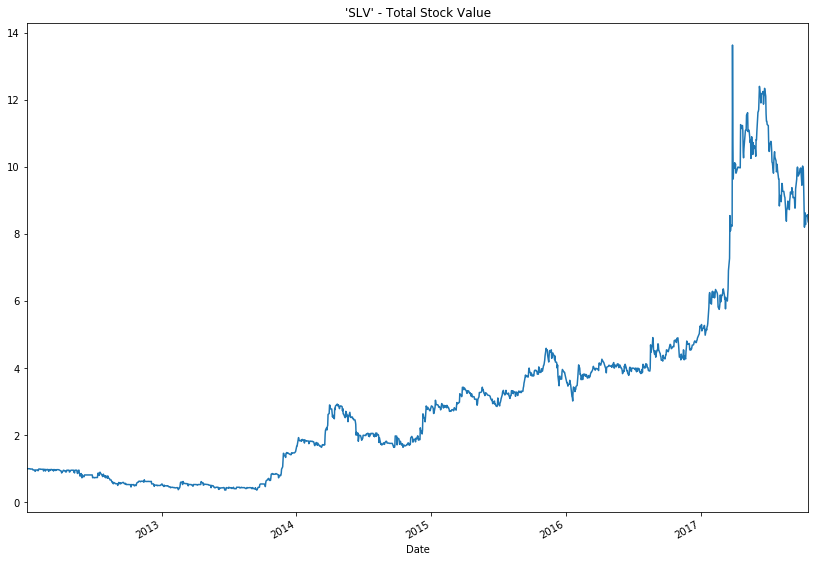

In [7]:
stock['Normed Return'].plot(figsize=(14,10))
plt.title(f"'{stock_symbol}' - Total Stock Value");

## Statistics

### Daily Returns

In [8]:
stock['Daily Return'] = stock['Close'].pct_change(1)

In [9]:
stock.tail()

,Close,Volume,Normed Return,Daily Return
Date,,,,
2017-10-13,46.98,5377,8.541818,0.031394
2017-10-16,47.00,17951,8.545455,0.000426
2017-10-17,47.17,5851,8.576364,0.003617
2017-10-18,46.55,1778,8.463636,-0.013144
2017-10-19,46.00,1003,8.363636,-0.011815


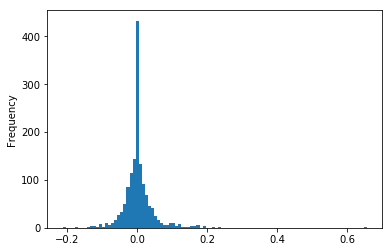

In [10]:
stock['Daily Return'].plot(kind='hist', bins=100);

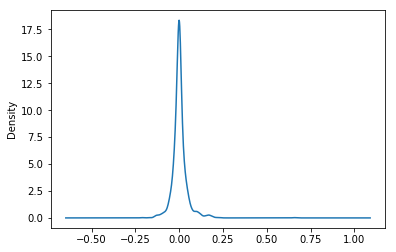

In [11]:
stock['Daily Return'].plot(kind='kde');

#### Average Daily Return

In [12]:
stock['Daily Return'].mean()

0.0023616691326473972

#### Std Daily Return

In [13]:
stock['Daily Return'].std()

0.043654361829169756

### Sharpe Ratio

In [14]:
SR = stock['Daily Return'].mean() / stock['Daily Return'].std()

if SR <= 1:
    print(f'Sharpe Ratio = {SR}. Too risky asset.')
elif SR <= 2:
    print(f'Sharpe Ratio = {SR}. Good.')
elif SR <= 3:
    print(f'Sharpe Ratio = {SR}. Great.')
else:
    print(f'Sharpe Ratio = {SR}. Excellent.')

Sharpe Ratio = 0.054099270581235134. Too risky asset.


In [15]:
ASR = (252**0.5) * SR
print(f'Annual Sharpe Ratio = {ASR}')

Annual Sharpe Ratio = 0.8587992964076454


### Moving Average

#### SMA

In [16]:
sma_1 = 10
sma_2 = 30

stock[f'SMA {sma_1}'] = stock['Close'].rolling(window=sma_1).mean()
stock[f'SMA {sma_2}'] = stock['Close'].rolling(window=sma_2).mean()

# crossovers
stock['signal'] = 0.0
stock['signal'][sma_1:] = np.where(stock[f'SMA {sma_1}'][sma_1:] > stock[f'SMA {sma_2}'][sma_1:], 1.0, 0.0)
stock['positions'] = stock['signal'].diff()

/Users/mariuszrokita/anaconda/envs/pyfinance/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


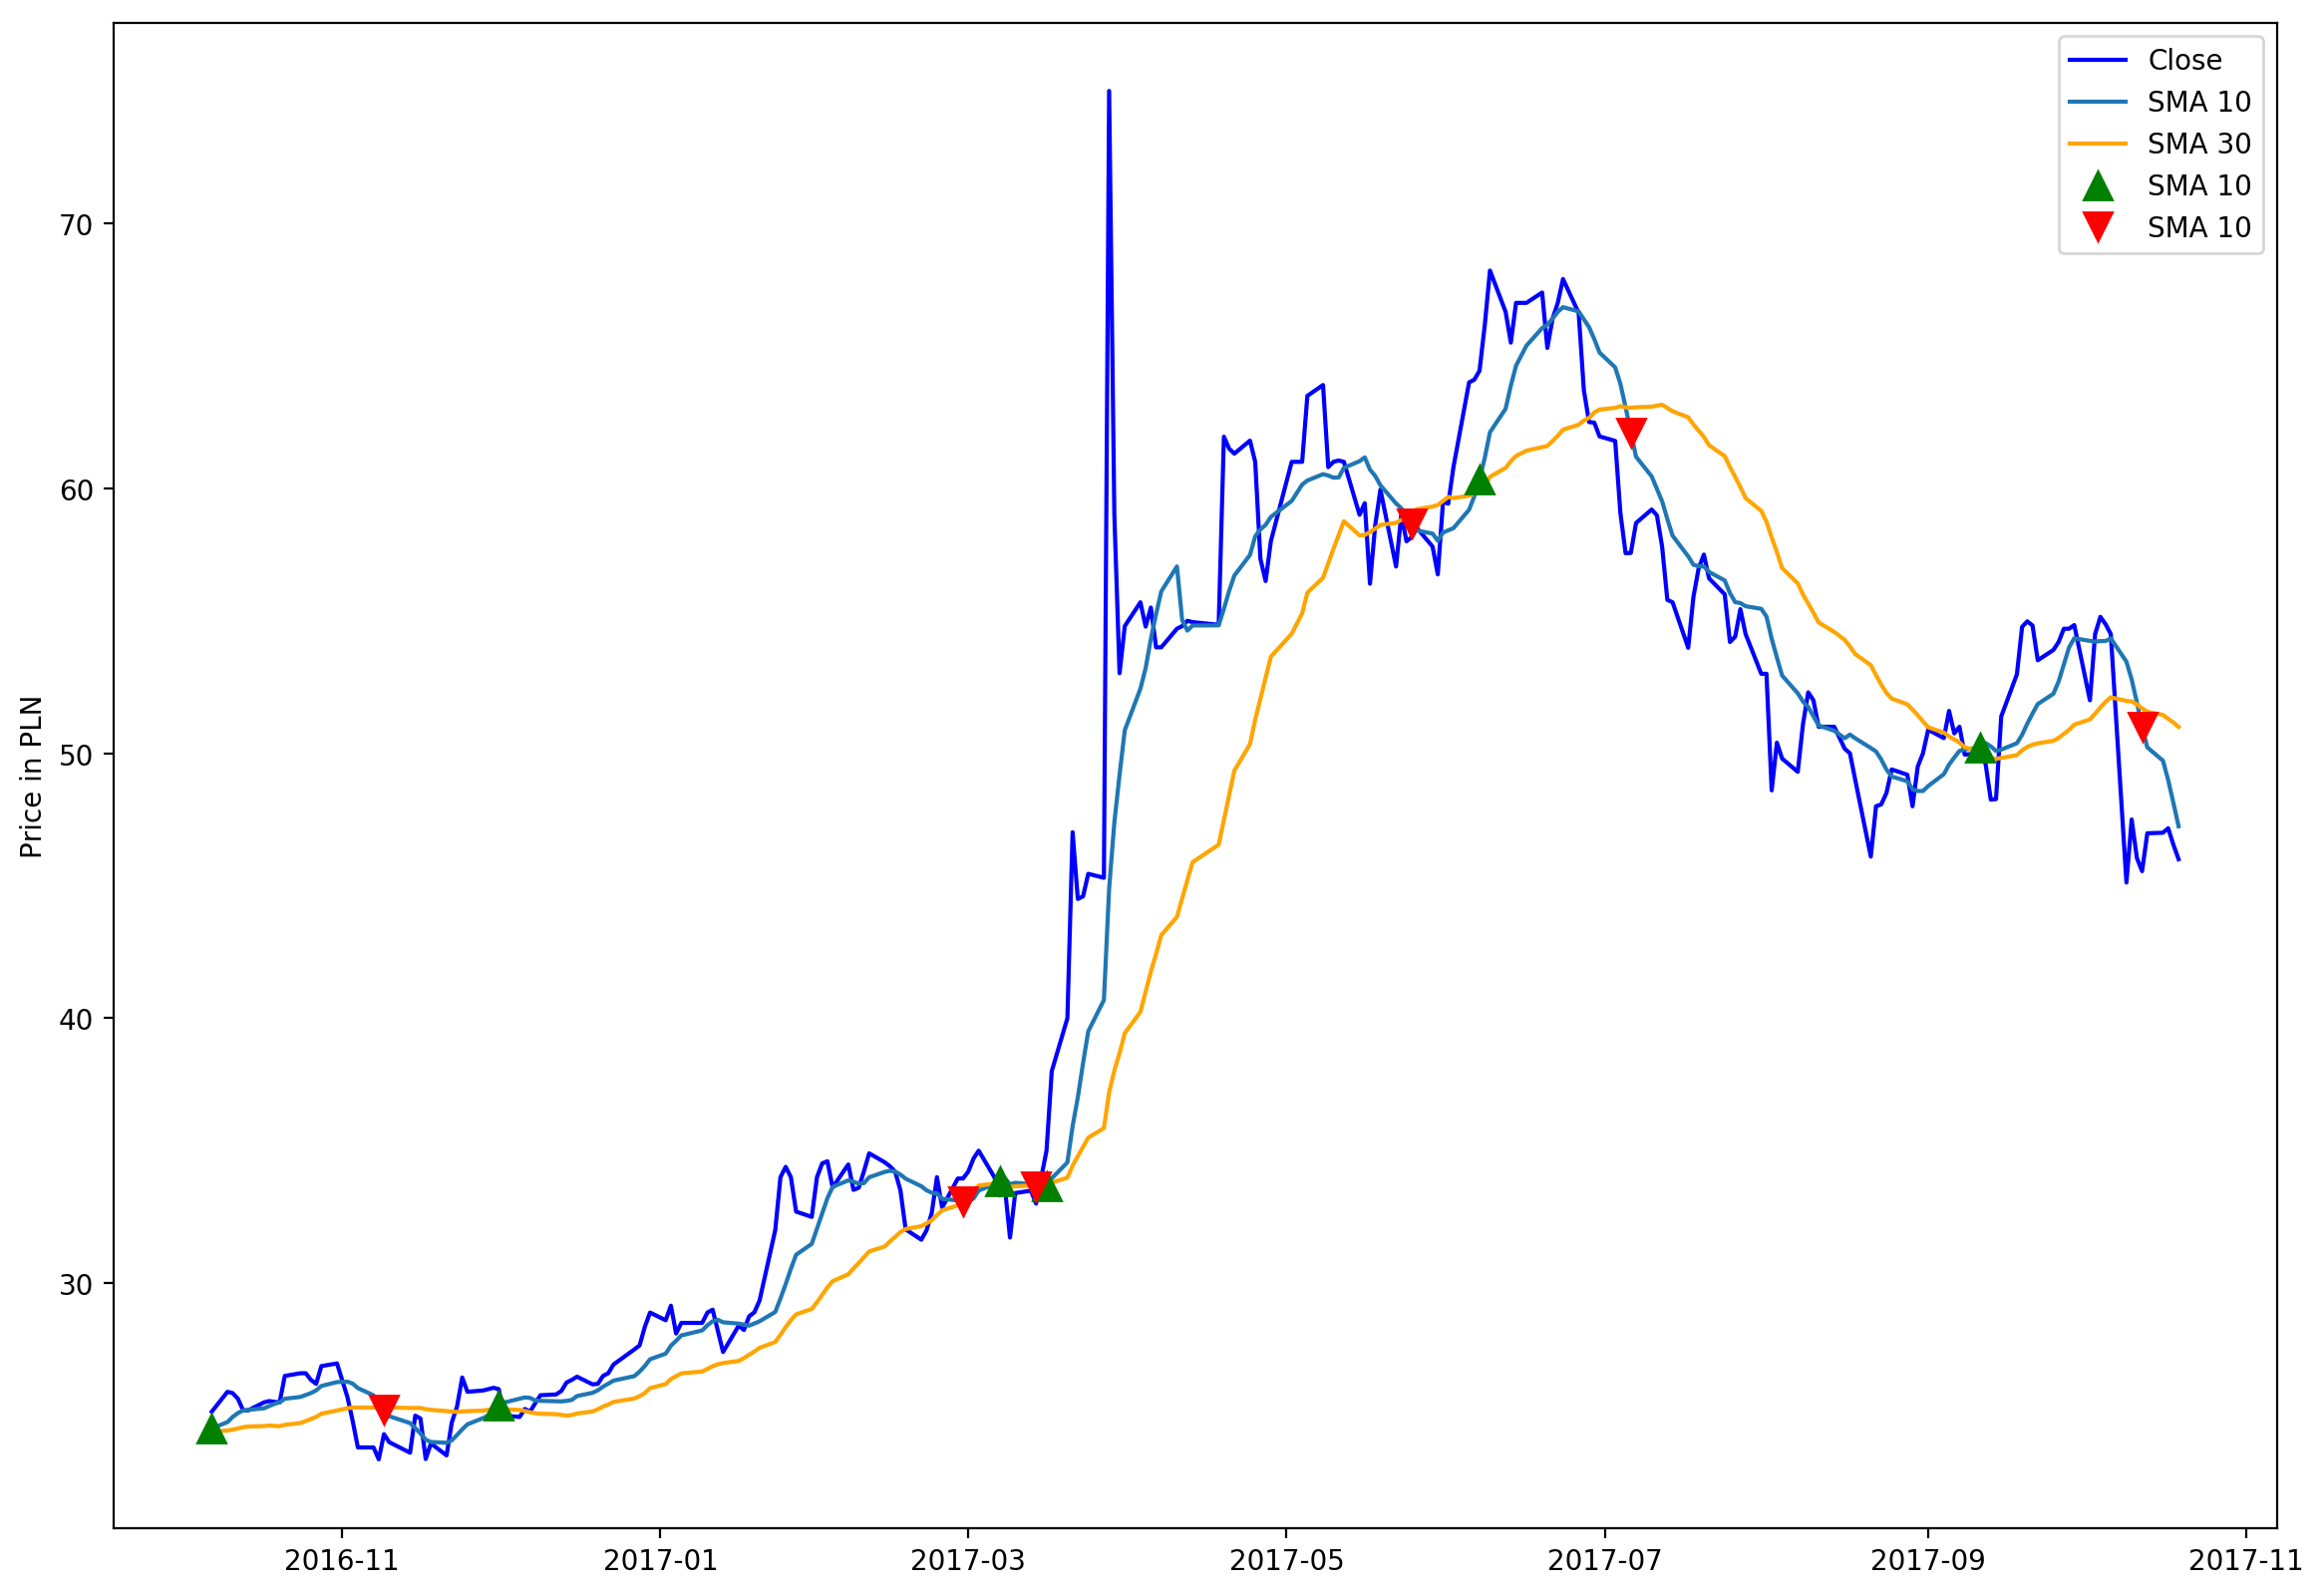

In [36]:
recent_stock = stock.tail(260);

fig = plt.figure(figsize=(14,10), dpi=200);
fig.patch.set_facecolor('white');     # Set the outer colour to white
ax1 = fig.add_subplot(111, ylabel='Price in PLN');

#stock['Close'].tail(260).plot(ax=ax1, color='r');
#stock[[f'SMA {sma_1}', f'SMA {sma_2}']].tail(260).plot(ax=ax1);

ax1.plot(recent_stock['Close'], color='blue')
ax1.plot(recent_stock[f'SMA {sma_1}'])
ax1.plot(recent_stock[f'SMA {sma_2}'], color='orange')

# Plot the "buy" trades
ax1.plot(recent_stock[recent_stock["positions"] == 1.0].index, 
         recent_stock[f'SMA {sma_1}'][recent_stock["positions"] == 1.0],
         '^', markersize=10, color='g');

# Plot the "sell" trades
ax1.plot(recent_stock[recent_stock["positions"] == -1.0].index, 
         recent_stock[f'SMA {sma_1}'][recent_stock['positions'] == -1.0],
         'v', markersize=10, color='r');

ax1.legend();

#### Suggested 'Buy' dates

In [18]:
recent_stock[recent_stock["positions"] == 1.0].index.tolist()

[Timestamp('2016-10-07 00:00:00'),
 Timestamp('2016-12-01 00:00:00'),
 Timestamp('2017-03-07 00:00:00'),
 Timestamp('2017-03-16 00:00:00'),
 Timestamp('2017-06-07 00:00:00'),
 Timestamp('2017-09-11 00:00:00')]

#### Suggested 'Sell' dates

In [19]:
recent_stock[recent_stock["positions"] == -1.0].index.tolist()

[Timestamp('2016-11-09 00:00:00'),
 Timestamp('2017-02-28 00:00:00'),
 Timestamp('2017-03-14 00:00:00'),
 Timestamp('2017-05-25 00:00:00'),
 Timestamp('2017-07-06 00:00:00'),
 Timestamp('2017-10-12 00:00:00')]

#### Bollinger Bands

In [20]:
stock['SMA 20'] = stock['Close'].rolling(window=20).mean()
stock['B-Band Upper'] = stock['SMA 20'] + 2*stock['Close'].rolling(window=20).std()
stock['B-Band Lower'] = stock['SMA 20'] - 2*stock['Close'].rolling(window=20).std()

In [21]:
stock['BB-signal'] = 0.0
stock['BB-signal'][20:] = np.where(stock['Close'][20:] >= stock['B-Band Upper'][20:], 1.0, 0.0)
stock['BB-sell-positions'] = stock['BB-signal'].diff()

stock['BB-signal'] = 0.0
stock['BB-signal'][20:] = np.where(stock['Close'][20:] <= stock['B-Band Lower'][20:], -1.0, 0.0)
stock['BB-buy-positions'] = stock['BB-signal'].diff()

recent_stock = stock.tail(260)

/Users/mariuszrokita/anaconda/envs/pyfinance/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mariuszrokita/anaconda/envs/pyfinance/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


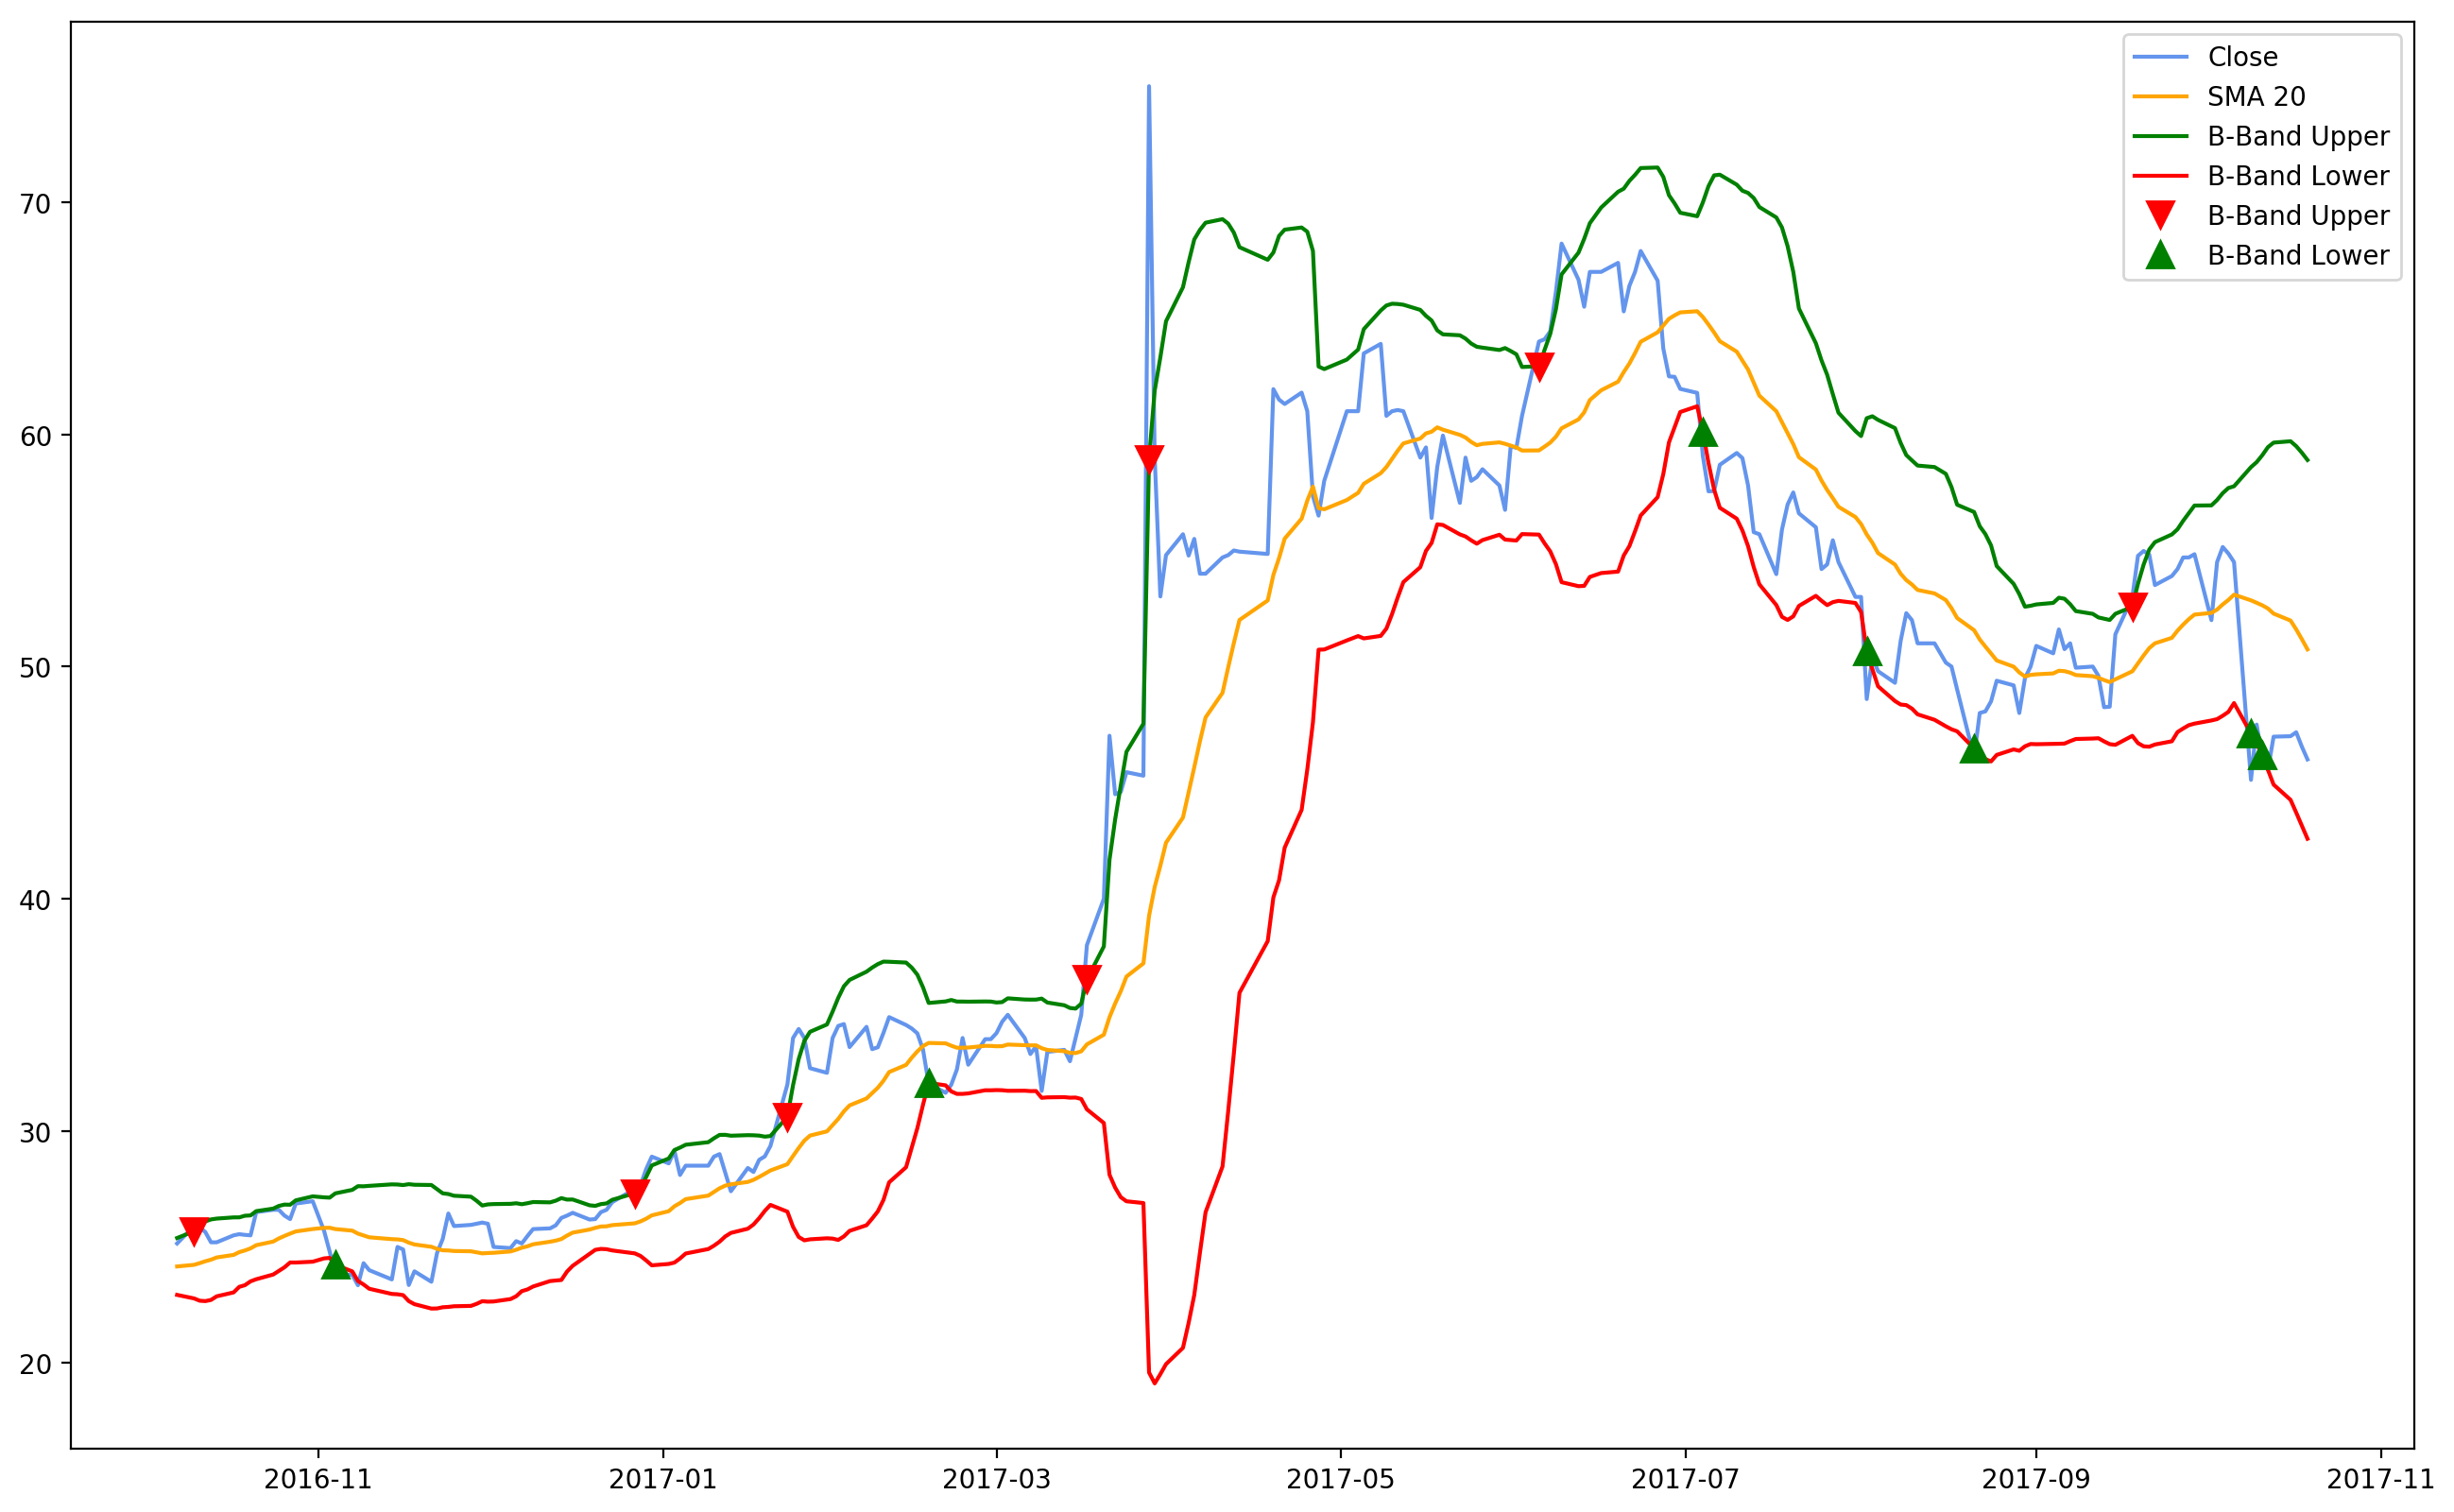

In [37]:
fig,ax1 = plt.subplots(figsize=(16,10), dpi=200);

ax1.plot(recent_stock['Close'], color='cornflowerblue')
ax1.plot(recent_stock['SMA 20'], color='orange')
ax1.plot(recent_stock['B-Band Upper'], color='green')
ax1.plot(recent_stock['B-Band Lower'], color='red')

# Plot the "sell" trades
ax1.plot(recent_stock[recent_stock["BB-sell-positions"] == 1.0].index, 
         recent_stock['B-Band Upper'][recent_stock["BB-sell-positions"] == 1.0],
         'v', markersize=10, color='r');

# Plot the "buy" trades
ax1.plot(recent_stock[recent_stock["BB-buy-positions"] == -1.0].index, 
         recent_stock['B-Band Lower'][recent_stock["BB-buy-positions"] == -1.0],
         '^', markersize=10, color='g');

ax1.legend();

#### Suggested 'Buy' dates

In [23]:
recent_stock[recent_stock["BB-buy-positions"] == -1.0].index.tolist()

[Timestamp('2016-11-04 00:00:00'),
 Timestamp('2017-02-17 00:00:00'),
 Timestamp('2017-07-04 00:00:00'),
 Timestamp('2017-08-02 00:00:00'),
 Timestamp('2017-08-21 00:00:00'),
 Timestamp('2017-10-09 00:00:00'),
 Timestamp('2017-10-11 00:00:00')]

#### Suggested 'Sell' dates

In [24]:
recent_stock[recent_stock["BB-sell-positions"] == 1.0].index.tolist()

[Timestamp('2016-10-10 00:00:00'),
 Timestamp('2016-12-27 00:00:00'),
 Timestamp('2017-01-23 00:00:00'),
 Timestamp('2017-03-17 00:00:00'),
 Timestamp('2017-03-28 00:00:00'),
 Timestamp('2017-06-05 00:00:00'),
 Timestamp('2017-09-18 00:00:00')]

In [25]:
#temp_values = [1,2,4,6,7,10];
#temp_index = pd.date_range(pd.datetime.today(), 
#                           periods = len(temp_values),
#                           normalize=True).tolist()
#temp_pd = pd.DataFrame(data=temp_values, index=temp_index)
#print(temp_pd)
#print(temp_pd.diff())

#### EWMA

In [26]:
stock[f'EWMA {sma_1}'] = stock['Close'].ewm(span=10).mean()
stock[f'EWMA {sma_2}'] = stock['Close'].ewm(span=20).mean()

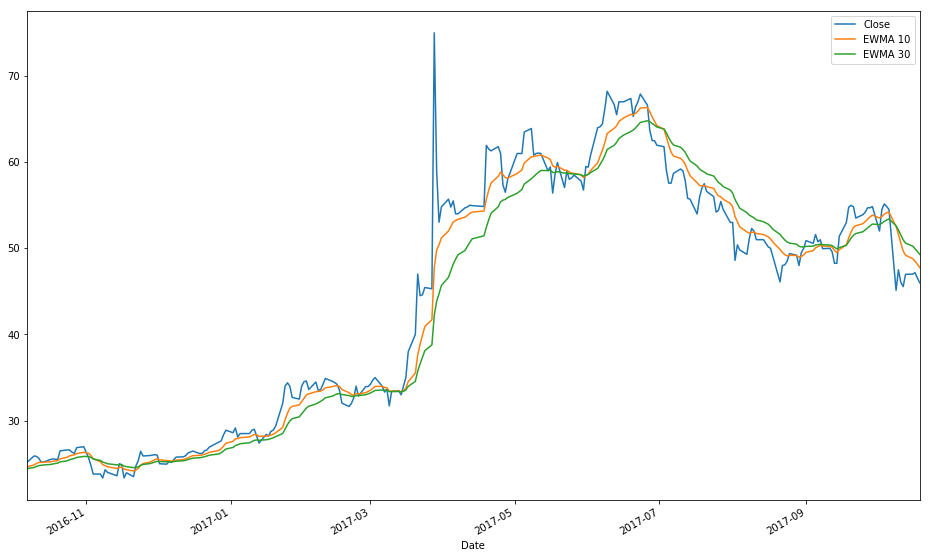

In [27]:
stock[['Close', f'EWMA {sma_1}', f'EWMA {sma_2}']].tail(260).plot(figsize=(16,10));

### ARIMA

In [28]:
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    print("")
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")

/Users/mariuszrokita/anaconda/envs/pyfinance/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [29]:
adf_check(stock['SMA 20'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.795744451778
p-value : 0.8203689077
#Lags Used : 23
Number of Observations Used : 1405

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [30]:
stock['SMA 20 - First Diff'] = stock['SMA 20'] - stock['SMA 20'].shift(1)
adf_check(stock['SMA 20 - First Diff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.67514679109
p-value : 9.36801807706e-05
#Lags Used : 22
Number of Observations Used : 1405

Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


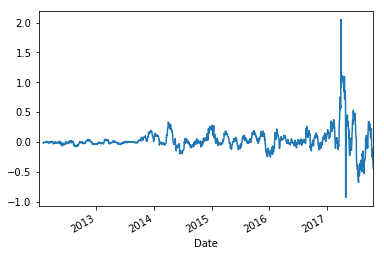

In [31]:
stock['SMA 20 - First Diff'].plot()

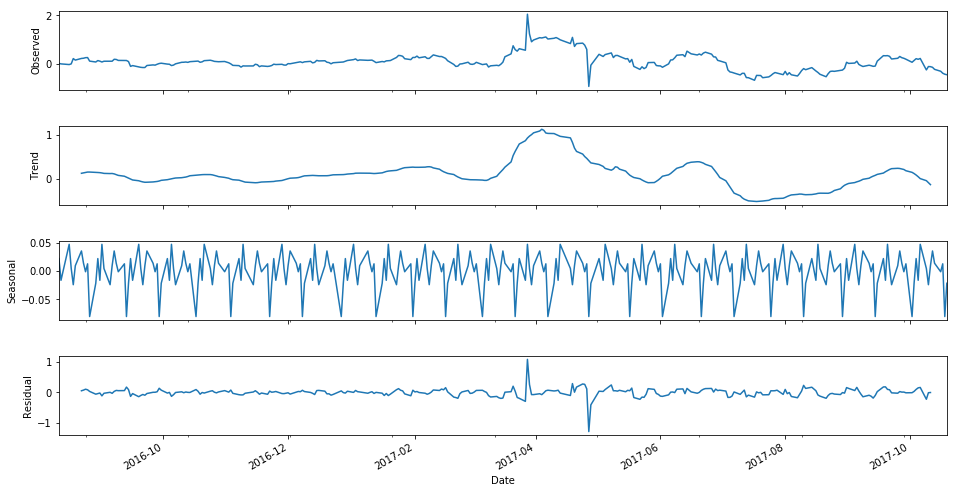

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(stock['SMA 20 - First Diff'].dropna().tail(300), freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [33]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(stock['SMA 20 - First Diff'].dropna().tail(300),order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
#print(results.summary())

In [34]:
#stock['forecast'] = results.predict(start = 1300, end= 1440, dynamic= True)  
#stock[['SMA 20 - First Diff','forecast']].plot(figsize=(12,8))